In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import scipy.io as sio
import torch
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import LinearLR

from splice import splice_model
from splice.base import *
from splice.loadCellsFile import *
from splice.utilities import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Preprocessing
The preprocessing code below is adapted from Carlos' notebook, with minor changes to variable names, using numpy instead of pandas, and slight optimizations

### Load the data

In [54]:
ratname = "A324"
sessdate = "2023_07_21"

session_info = mat2pyCellFileCleanup("../data/uberphys/%s_%s.mat" % (ratname, sessdate))
session_data = scipy.io.loadmat("../data/uberphys/%s_%s.mat" % (ratname, sessdate)) 

included_trials = np.argwhere((session_info["Trials"]['violated'] == 0) & ((~np.isnan(session_info["Trials"]["pokedR"])))).squeeze()
n_trials = included_trials.shape[0]
cpoke_in = session_info["Trials"]["stateTimes"]["cpoke_in"][included_trials]
cpoke_out = session_info["Trials"]["stateTimes"]["cpoke_out"][included_trials]

included_cells = np.argwhere(session_data['standard_inclusion_criteria'].squeeze()).squeeze()
brain_region = np.array(session_info['region'])[included_cells]

print(f"We have {n_trials} non-violation, valid trials")

No region found for cell 190, entering 'None'
No region found for cell 191, entering 'None'
No region found for cell 192, entering 'None'
No region found for cell 193, entering 'None'
No region found for cell 194, entering 'None'
No region found for cell 195, entering 'None'
No region found for cell 196, entering 'None'
No region found for cell 197, entering 'None'
No region found for cell 198, entering 'None'
No region found for cell 199, entering 'None'
No region found for cell 200, entering 'None'
No region found for cell 201, entering 'None'
No region found for cell 202, entering 'None'
No region found for cell 203, entering 'None'
No region found for cell 547, entering 'None'
No region found for cell 2202, entering 'None'
No region found for cell 2203, entering 'None'
No region found for cell 2204, entering 'None'
We have 714 non-violation, valid trials


### Bin and smooth firing rates
Here we bin spikes into 10 ms bins; then smooth with a 60ms sd Gaussian; then subsample down by 3.

We end up with **time_in_session**, a time in session vector, and **smoothed_rates**, an nCells x nTimebins matrix of smoothed firing rates (no trial structure yet)

In [12]:
spike_times= session_data['raw_spike_time_s'].squeeze()[included]
n_cells = spike_times.shape[0]
print(f"We have {n_cells} cells total")

We have 2621 cells total


In [13]:
min_time = np.inf
max_time = -np.inf

for cell in spike_times:
    if len(cell) > 0:
        min_time = min(min_time, cell[0])
        max_time = max(max_time, cell[-1])

min_time = min_time[0]
max_time = max_time[0]
print(f"Min time: {min_time}, Max time: {max_time}")
    

Min time: 1658.66378, Max time: 14362.02429


In [14]:
dt = 0.01
bin_times = np.arange(np.floor(min_time), np.ceil(max_time), dt)
smooth_sigma = 0.06 # in seconds
subsample_factor = 3

filepath = f"../data/uberphys/%s_%s_%.3f_smoothed_rates.npz" % (ratname, sessdate, smooth_sigma)

if(os.path.exists(filepath)):
    data = np.load(filepath)
    smoothed_rates = data['smoothed_rates']
    time_in_session = data['time_in_session']
    print("Loaded smoothed rates from file")
else:
    time_in_session = bin_times[0:-1:subsample_factor]
    smoothed_rates = np.zeros((n_cells, len(time_in_session)))

    for cell in range(n_cells):
        if smooth_sigma == 0:
            smoothed_rates[cell] = binEvents(spike_times[cell], bin_times, dt)[0:-1:subsample_factor]/dt
        else:
            smoothed_rates[cell] = smoothIt(binEvents(spike_times[cell], bin_times, dt), smooth_sigma/dt)[0:-1:subsample_factor]/dt
        
        print(f"Done with {cell+1}/{n_cells} cells", end="\r")
    
    np.savez_compressed(filepath, smoothed_rates=smoothed_rates, time_in_session=time_in_session)

Loaded smoothed rates from file


### Put times into trials

We'll make a tensor **trial_rates**, nTrials x nCells x nTimebins, where nTimebins now just runs over `cpoke_in` to `cpoke_out`.

Note that different trials are different lengths.  We're timelocked to `cpoke_in`, but some will have `np.nan`s in their last timebins

In [64]:
trial_length = 0.5

trial_rates = np.zeros((n_trials, n_cells, int(np.ceil(trial_length/(dt*subsample_factor)))))
trial_times = list(np.arange(trial_rates.shape[-1])*(dt*subsample_factor))

for trial in range(n_trials):
    start = cpoke_in[trial]
    end = cpoke_out[trial]

    rates = smoothed_rates[:, (time_in_session >= start) & (time_in_session < end)]

    if rates.shape[1] > trial_rates.shape[-1]:
        add_length = rates.shape[1] - trial_rates.shape[-1]
        trial_rates = np.concatenate((trial_rates, np.nan * np.zeros((n_trials, n_cells, add_length))), axis=-1)

        new_times = list(trial_times[-1] + np.arange(1, (add_length+1))*(dt*subsample_factor))

        if new_times:
            trial_times.extend(new_times)
    
    trial_rates[trial, :, :rates.shape[1]] = rates

trial_times = np.array(trial_times)

### Concatenate all non-NaN timebins across trials

In [74]:
concatenated_rates = trial_rates.transpose(0, 2, 1).reshape(-1, n_cells)
concatenated_rates = concatenated_rates[~np.isnan(concatenated_rates[:,0]), :500]
concatenated_rates.shape

(40779, 500)

## Do things

### Pick out cells from a brain region 

In [ ]:
np.unique(brain_region)

array(['ADS', 'CC', 'Cg1', 'DGd', 'DGv', 'DS', 'GP', 'M1', 'M2', 'MGB',
       'NAc', 'None', 'PrL', 'S1', 'SBN', 'TS'], dtype='<U4')

In [ ]:
selected_region = "Cg1"
selected_cells = np.argwhere(brain_region == selected_region).squeeze()

selected_spike_times = spike_times[selected_cells]
selected_smoothed_rates = smoothed_rates[selected_cells]
print(f"We have {selected_spike_times.shape[0]} cells in {selected_region}")

We have 305 cells in Cg1


## Uberphys

In [61]:
npz = np.load("../data/uberphys/A324_2023-07-21.npz")
rates = npz["trialRates"]

In [6]:
npz["README"]

array('Firing rates for all 714 trials, all 2565 cells, over 139 timesteps of 0.03 seconds each.\n\nEach trial starts at cpoke_in and runs until cpoke_out.\nNaNs are used to pad the end of trials that are shorter than the longest trial.\nbrainRegionsList is a vector of strings, indicating which brain region each unit came from.\n\nFiring rates were computed by smoothing the spike times with a Gaussian kernel of sigma 0.06 seconds,\nthen sampling every 30 ms.\n',
      dtype='<U449')

In [4]:
export_rates = np.zeros((714*139, 2565))
for neuron in range(2565):
    for trial in range(714):
        for time in range(139):
            export_rates[trial*139+time, neuron] = rates[trial, neuron, time]

In [5]:
export_rates = export_rates[~np.isnan(export_rates[:,0]), :500]

In [6]:
export_rates.shape

(40681, 500)

In [7]:
x_train = np.vstack((export_rates[0:20000], export_rates[25000:]))
x_test = export_rates[20000:25000]

In [8]:
x_train.shape, x_test.shape

((35681, 500), (5000, 500))

### PCA

In [9]:
dims = np.array([1,2,3,4,5,7,10,15, 20, 30 , 50])
pca_loss = np.zeros(len(dims))

In [10]:
for i,dim in enumerate(dims):
    pca = PCA(n_components=dim)
    pca.fit(x_train)
    pca_loss[i] = F.mse_loss(torch.Tensor(pca.inverse_transform(pca.transform(x_test))), torch.Tensor(x_test), reduction="mean")

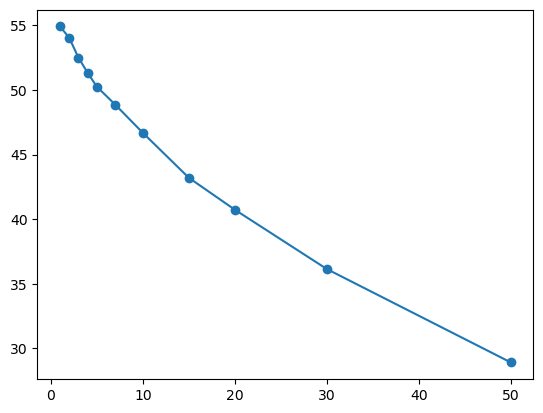

In [11]:
plt.plot(dims, pca_loss, marker='o')

### Autoencoder

In [12]:
x_train = torch.Tensor(x_train).to(device)
x_test = torch.Tensor(x_test).to(device)

In [13]:
class autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, layers):
        super(autoencoder, self).__init__()
        self.encoder = encoder(input_dim, bottleneck_dim, layers)
        self.decoder = decoder(bottleneck_dim, input_dim, layers[::-1])

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
dims = np.array([1,2,3,4,5,7,10,15, 20, 30 , 50])
ae_loss = np.ones(len(dims)) * 100

lr = 1e-3
batch_size = x_train.shape[0]
epochs = 10000

for j,dim in enumerate(dims):
    print(f"------------ DIM = {dim} -------------")
    ae = autoencoder(x_test.shape[1], dim, [200,200,200,200]).to(device)
    ae.train()
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    scheduler = LinearLR(
        optimizer, total_iters=epochs, start_factor=1, end_factor=1/50
    )

    for epoch in range(epochs):
        print(epoch, end="\r")
        for i in range(int(len(x_train)/batch_size)):
            x = x_train[i*batch_size:(i+1)*batch_size]
            y = ae(x)
            loss = torch.nn.functional.mse_loss(y, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        scheduler.step()
            
        if epoch % 500 == 0:
            test_loss = F.mse_loss(ae(torch.Tensor(x_test)), torch.Tensor(x_test))
            print(f"epoch {epoch}, train loss: {loss.item():.5f}, test loss: {test_loss.item():.5f}")

            if test_loss < ae_loss[j]:
                ae_loss[j] = test_loss.item()

------------ DIM = 1 -------------
epoch 0, train loss: 755.59680, test loss: 167.92265
epoch 500, train loss: 58.68704, test loss: 57.71771
epoch 1000, train loss: 58.68704, test loss: 57.71771
epoch 1500, train loss: 58.68704, test loss: 57.71771
epoch 2000, train loss: 58.68704, test loss: 57.71771


KeyboardInterrupt: 